In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests

headers = headers = {"User-Agent": "Mozilla/5.0 (X11; CrOS x86_64 12871.102.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.141 Safari/537.36"}

# Data Collection

## Target Data
Want to predict American spending on Christmas in 2023 based on data in previous years. Data collected from National Retail Federation

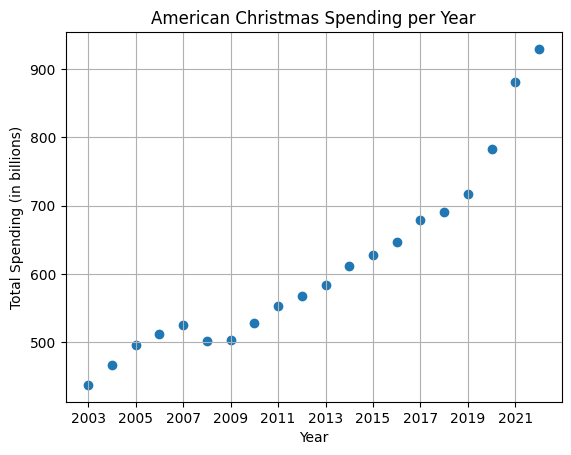

In [107]:
time = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

# in billions of dollars
nrf_data = [437.6, 467.2, 496.0, 512.1, 526.0, 501.5, 502.7, 528.8, 553.3, 567.6, 583.2, 611.1, 628.0, 646.7, 678.9, 690.8, 716.9, 782.3, 881.6, 929.5]


# create initial plot of the data


plt.scatter(time, nrf_data, marker='o')

plt.xlabel('Year')
plt.ylabel('Total Spending (in billions)')
plt.title('American Christmas Spending per Year')
plt.xticks(time[::2])
plt.grid()
plt.show()

## Features

Creating features here might be a bit difficult. Here's some main ideas:

- [x] American GDP
- [x] American Population
- [x] Median income (need current year estimate) *
- [ ] Previous year's spending (note that to include this, we need to remove 2003)
- [x] Unemployment rate (nned current year estimate)
- [x] Consumer Confidence Index
- [x] Interest Rate
- [x] Inflation Rate
- [ ] Taxation (will omit for now)
- [x] Real estate market

It's also important we get the information for the current year!

### GDP

In [108]:
# US GDP (in billions) Data 2003-2022
# from https://www.macrotrends.net/countries/USA/united-states/gdp-gross-domestic-product
us_gdp = [
    11456.44,
    12217.19,
    13039.20,
    13815.59,
    14474.23,
    14769.86,
    14478.06,
    15048.96,
    15599.73,
    16253.97,
    16843.19,
    17550.68,
    18206.02,
    18695.11,
    19477.34,
    20533.06,
    21380.98,
    21060.47,
    23315.08,
    25462.70
]


# GDP for 2023 (best estimate)
# from https://www.visualcapitalist.com/visualizing-u-s-gdp-by-industry-in-2023/, 26.5

us_gdp += [26500.00]

### Population

In [147]:
# US population
# Using beautifulsoup from same website
url_pop = 'https://www.macrotrends.net/countries/USA/united-states/population'
content_pop = requests.get(url_pop, headers=headers)

In [148]:
s = BeautifulSoup(content_pop.text, 'html.parser')

# select table
a = s.find_all('table', class_='historical_data_table table table-striped table-bordered')[1]

# starts from idx 2 is 2023, idx 22 is 2003
us_pop = []

for i in range(22, 1, -1):
    us_pop.append(int(a.find_all('tr')[i].text.strip()[5:16].replace(',', '')))

IndexError: list index out of range

### Income

In [111]:
# US median income
# From US Social Security
url_income = 'https://www.ssa.gov/oact/cola/central.html'
content_income = requests.get(url_income, headers=headers)

In [112]:
income_soup = BeautifulSoup(content_income.text, 'html.parser')

us_med_income = []

for i in range(15, 35):
    us_med_income.append(float(income_soup.find('table').find_all('tr')[i].text.split(' ')[3].replace(',', '')))

# best estimates in this form are yet to exist, but it's safe to assume change has been in the range of 1-2k.

us_med_income += [41500]   

### Unemployment

In [113]:
# Unemployment rate
# from investopedia

url_unem = 'https://www.investopedia.com/historical-us-unemployment-rate-by-year-7495494'
content_unem = requests.get(url_unem, headers=headers)

In [114]:
unem = BeautifulSoup(content_unem.text, 'html.parser')

us_unem = []
# 2003 to 2022 occurs at 76 through 95
for i in range(76, 96):
    data = unem.find('table', class_='mntl-sc-block-table__table').find_all('tr')[i].text
    us_unem.append(float(data[6:data.find('%')]))

# from statista, best estimate for 2023 is 3.5%
    
us_unem += [3.5]

### Consumer Confidence Index

In [115]:
# from OECD
cci_df = pd.read_csv('data/DP_LIVE_26122023055003422.csv')

cci_df = cci_df[cci_df['LOCATION'] == 'USA']

cci_df['TIME'] = pd.to_datetime(cci_df['TIME'])

us_cci = cci_df[(cci_df['TIME'].dt.year >= 2003) & (cci_df['TIME'].dt.month == 11)]['Value'].values

### Interest Rate

In [116]:
# US Intrest Rate per year
# From FRED
interest_df = pd.read_csv('data/FEDFUNDS.csv')

# get things of interest
interest_df['DATE'] = pd.to_datetime(interest_df['DATE'])
filtered_interest_df = interest_df[(interest_df['DATE'].dt.year >= 2003) & (interest_df['DATE'].dt.year <= 2023) & (interest_df['DATE'].dt.month == 11) & (interest_df['DATE'].dt.day == 1)]
us_interest = filtered_interest_df['FEDFUNDS'].values

### Inflation Rate

In [117]:
# US Inflation rate
inflation_url = 'https://www.usinflationcalculator.com/inflation/current-inflation-rates/'
inflation_content = requests.get(inflation_url, headers=headers)

In [118]:
inflation_soup = BeautifulSoup(inflation_content.text, 'html.parser')

us_inflation = []
# Take November Inflation rate
for i in range(21, 0, -1):
    us_inflation.append(float(inflation_soup.find('table').find_all('tr')[i].text.split('\n')[12]))

### Real Estate

In [119]:
# Real estate information
# From FRED

re_df = pd.read_csv('data/ASPUS.csv')

re_df['DATE'] = pd.to_datetime(re_df['DATE'])

# get most recent from this year and patch from previous years
us_re = re_df[(re_df['DATE'].dt.year >= 2003) & (re_df['DATE'].dt.month == 7)]['ASPUS'].values

## EDA

In [200]:
variables = {
    'year' : np.arange(2003, 2024),
    'gdp' : us_gdp,
    'population' : us_pop,
    'unemployment_rate': us_unem,
    'interest_rate' : us_interest,
    'inflation_rate' : us_inflation,
    'real_estate_sales' : us_re
}

df = pd.read_csv('data/raw_data.csv').drop('Unnamed: 0', axis=1).iloc[:-1]
spending = pd.Series(nrf_data)


test_data = pd.read_csv('data/raw_data.csv').drop('Unnamed: 0', axis=1).iloc[[-1]]

In [202]:
# first, we want to standardize all feature variables

from sklearn.preprocessing import StandardScaler

features = ['gdp', 'population', 'unemployment_rate', 'interest_rate', 'inflation_rate', 'real_estate_sales']

s_training = StandardScaler()

df[features] = s_training.fit_transform(df[features])

test_data[features] = s_training.transform(test_data[features].values)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [174]:
# we also want to scale the target variable, but we will do so manually
# so that we can unscale it later
mu_y = spending.mean()
sigma_y = spending.std()

spending = (spending - mu_y) / (sigma_y)

### Correlation

First, let's take a look at the correlation coefficients of each with respect to the response

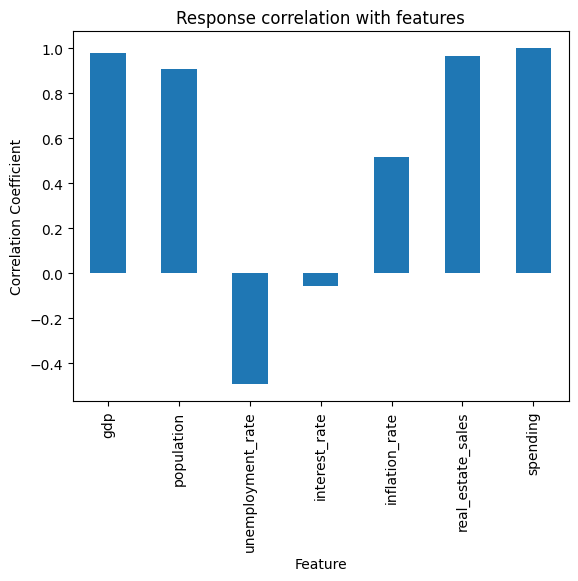

In [187]:
full_df = df.copy()[features]

full_df['spending'] = spending

full_df.corr()['spending'].plot(kind='bar')

plt.xlabel('Feature')
plt.ylabel('Correlation Coefficient')
plt.title('Response correlation with features')

plt.show()

So far, it seems that GDP, Population, Inflation Rate and Real Estate Sales are most highly correlated. However, we don't want any correlation within the